In [1]:
import tensorflow as tf
import tensorflow as tf; print(tf.__version__)
from spacy.lang.en import English

import tensorflow as tf
import datetime

import pandas as pd
from spacy.lang.en import English
import spacy
import re

2.4.0


In [2]:
df=pd.read_csv(r'C:\Users\SHEEL\Desktop\IXXO\defensecommune_ai\Btc-tweets.csv')
df.shape

(29131, 4)

In [3]:
df.head()

,Unnamed: 0,index,Tweet,Label
0,0,2,RT @tippereconomy: Another use case for #block...,1.0
1,1,3,free coins https://t.co/DiuoePJdap,1.0
2,2,4,RT @payvxofficial: WE are happy to announce th...,1.0
3,3,5,Copy successful traders automatically with Bit...,1.0
4,4,6,RT @bethereumteam: We're revealing our surpris...,1.0


In [5]:
df['Label'].value_counts()
df = df.rename(columns={'Tweet':'Text'})


In [8]:
type(df['Text'][0])

str

In [11]:
#Data Cleanups


df['Text']=df['Text'].str.replace('\n','')
df['Text']=df['Text'].str.replace('\r','')
df['Text']=df['Text'].str.replace('\t','')
  
  #This removes unwanted Texts
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[0-9]','',x))
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[/(){}\[\]\|@,;.:-]',' ',x))
  
  #Converting all upper case to lower case
df['Text']= df['Text'].apply(lambda s:s.lower() if type(s) == str else s)
  

  #Remove un necessary white space
df['Text']=df['Text'].str.replace('  ',' ')

  #Remove Stop words
nlp=spacy.load("en_core_web_sm")
df['Text'] =df['Text'].apply(lambda x: ' '.join([word for word in x.split() if nlp.vocab[word].is_stop==False ]))

AttributeError: 'StringMethods' object has no attribute 'apply'

In [6]:
df.head()

,Unnamed: 0,Label,Text
0,0,0,coronavirus created government lab bioweapon r...
1,1,0,lie coronavirus came bat pangolin concocted ch...
2,2,0,health experts predicted virus kill million pe...
3,3,0,video clip supposedly showed exponential sprea...
4,4,1,people italy died coronavirus hour period march


In [7]:
#Lemmenization
#Time module is just to measure the time it took as i was comparing Spacy, NLTK and Gensim. Spacy was the fastest
sp = spacy.load('en_core_web_sm')
import time
t1=time.time()
output=[]

for sentence in df['Text']:
    sentence=sp(str(sentence))
    s=[token.lemma_ for token in sentence]
    output.append(' '.join(s))
df['processed']=pd.Series(output)
t=time.time()-t1
print("Time" + str(t))

Time94.14915299415588


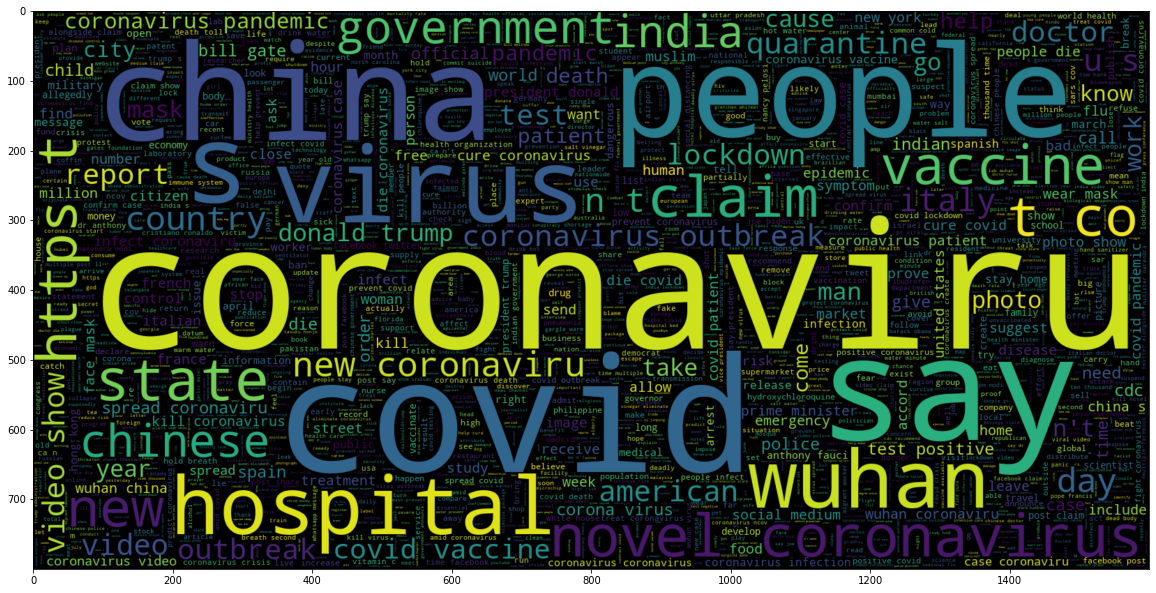

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.Label == 0].processed))
plt.imshow(wc , interpolation = 'bilinear')

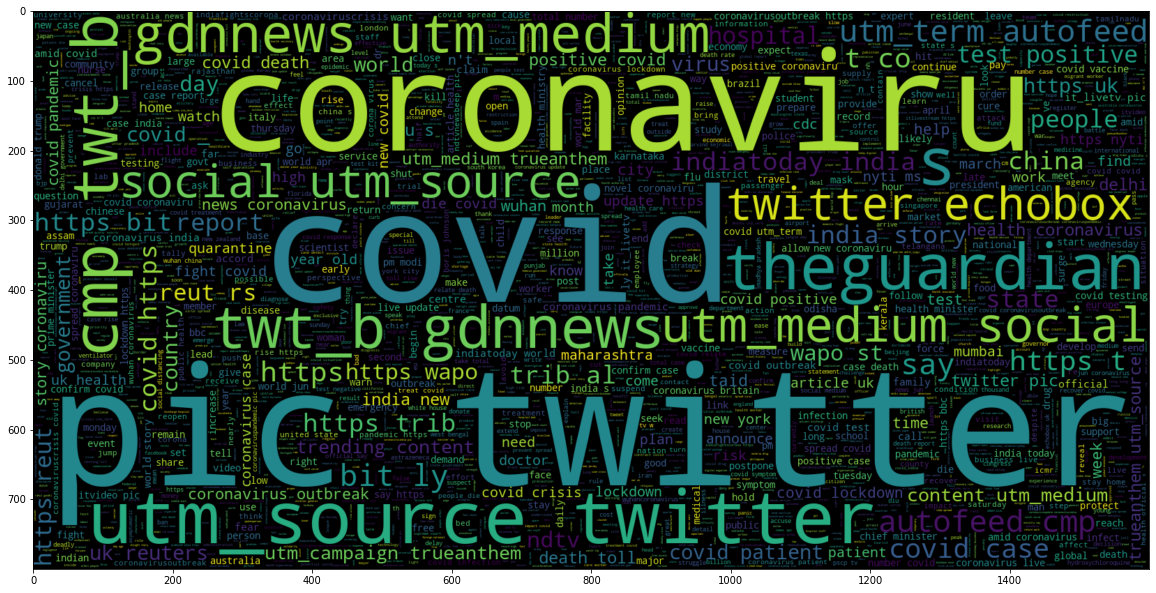

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.Label == 1].processed))
plt.imshow(wc , interpolation = 'bilinear')

In [10]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 20015
embedding_dim = 64
max_length = 70
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000
#Tokenization

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['processed'].values)
word_index = tokenizer.word_index
print(len(word_index))

20015


In [11]:
X = tokenizer.texts_to_sequences(df['processed'].values)                         #Tokenize the dataset
X = pad_sequences(X, maxlen=max_length)     #Padding the dataset
Y=df['Label']                                                                   #Assign the value of y  
print(Y.shape)

(16925,)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.20,random_state=41)

In [20]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 64)            1280960   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 70, 64)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 70, 256)           197632    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 70, 128)           164352    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [14]:
import numpy as np
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train.shape

(13540, 70)

In [21]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=64,shuffle=True,verbose = 1)


Epoch 1/5
212/212 [==============================] - 29s 85ms/step - loss: 0.3997 - accuracy: 0.8149 - val_loss: 0.2365 - val_accuracy: 0.9093
Epoch 2/5
212/212 [==============================] - 15s 70ms/step - loss: 0.1657 - accuracy: 0.9359 - val_loss: 0.2576 - val_accuracy: 0.9126
Epoch 3/5
212/212 [==============================] - 16s 78ms/step - loss: 0.0875 - accuracy: 0.9704 - val_loss: 0.2840 - val_accuracy: 0.8960
Epoch 4/5
212/212 [==============================] - 15s 72ms/step - loss: 0.0501 - accuracy: 0.9832 - val_loss: 0.3015 - val_accuracy: 0.8969
Epoch 5/5
212/212 [==============================] - 14s 65ms/step - loss: 0.0380 - accuracy: 0.9873 - val_loss: 0.4369 - val_accuracy: 0.9052


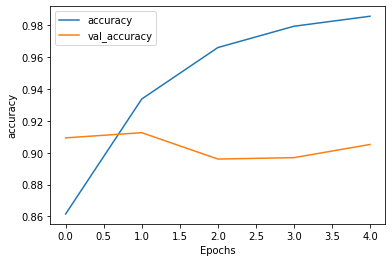

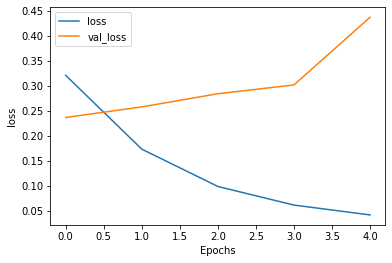

In [22]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [23]:
y_predict=model.predict(X_test)
y_predict = np.around(y_predict, decimals = 0)
y_predict

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [24]:
from sklearn.metrics import confusion_matrix
cf=confusion_matrix(y_test,y_predict)
cf

array([[2088,  172],
       [ 149,  976]], dtype=int64)

In [25]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
c_report=classification_report(y_test,y_predict,target_names = ['0','1'])
print(c_report)

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2260
           1       0.85      0.87      0.86      1125

    accuracy                           0.91      3385
   macro avg       0.89      0.90      0.89      3385
weighted avg       0.91      0.91      0.91      3385



In [26]:
model.save(r'C:\Users\SHEEL\Desktop\IXXO\defensecommune_ai\CVD_model.h5')

In [27]:
import joblib
joblib.dump(tokenizer, r'C:\Users\SHEEL\Desktop\IXXO\defensecommune_ai\CVD_tokenizer.pkl')

['C:\\Users\\SHEEL\\Desktop\\IXXO\\defensecommune_ai\\CVD_tokenizer.pkl']